### 1. Extract Hru size from output.std to reproduce the SWAT Check table

In [1]:
### Hru size
import pandas as pd

def HRUsize(file_path, str1, str2):
    lines = []
    found_str1 = False

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing whitespaces
            
            # Skip blank lines
            if not line:
                continue
            
            # If str1 is found, start storing lines
            if str1 in line:
                found_str1 = True
                continue  # Skip storing str1 itself
            
            # If str2 is found, stop storing lines
            if str2 in line and found_str1:
                break
            
            # Store lines if str1 has been found
            if found_str1:
                # Split the line into columns based on the tab delimiter
                columns = line.split()
                lines.append(columns)
    
    column_names = lines[0]
    # Create a DataFrame from the stored lines
    df = pd.DataFrame(lines[1:],columns=column_names)
    size=df['AREAkm2']
    size = size.astype(float)
    return size

# Example to run:
file_path = 'output.std'
str1 = 'AVE ANNUAL VALUES'
str2 = 'AVE MONTHLY BASIN VALUES'
size =HRUsize(file_path, str1, str2)

In [2]:
size
#print(size) #works as well

0      0.321
1      0.442
2      0.573
3      2.500
4      2.860
       ...  
64     2.780
65     4.250
66    11.500
67     3.330
68     5.700
Name: AREAkm2, Length: 69, dtype: float64

### 2. Extract target variable from output.hru

In [3]:
### to student v1: output hru
def process_data(file_path, n_Y, n_hru, skip_lines, feature_to_extract):
    # Initialize an empty list to store data
    data = []

    # Open the file and read line by line, skipping the first 9 lines
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip lines

        # Read the remaining lines
        for line in file:
            # Split the line based on space delimiter
            split_line = line.split()
            # Append the split line to data
            data.append(split_line)

    # Create a DataFrame from the data
    df = pd.DataFrame(data)

    # Select specific columns from the DataFrame
    target_df = df.iloc[:, feature_to_extract].copy()
    target_df.rename(columns={0: 'LUC', 1: 'HRU', 3: 'SUB',12:'SW', 69: 'BIOM', 71: 'YLD'}, inplace=True)
    ana_avr_df = target_df.tail(n_hru)

    # Initialize an empty list to store DataFrames
    dfs = []
    year_df = target_df.copy()[:-n_hru]  # Make a copy for month_df

    # Loop over n_Y and create DataFrames for each year
    for i in range(n_Y):
        # Extract rows for the current year
        new_df_indices = range((13 * i * n_hru), ((13 * (i + 1) - 1) * n_hru))
        new_df = target_df.iloc[new_df_indices]
        
        # Remove the rows for the current year from month_df
        year_df =year_df.drop(new_df_indices)
       
        # Append the DataFrame for the current year to the list
        new_df.reset_index(drop=True, inplace=True)
        dfs.append(new_df)

    # Concatenate all DataFrames in the list for year_df
    year_df.reset_index(drop=True, inplace=True)
    ana_avr_df.reset_index(drop=True, inplace=True)
    ana_avr_df = ana_avr_df.astype({'SUB':int,'HRU':int,'SW':float,'BIOM': float, 'YLD': float})  
    month_df = pd.concat(dfs, ignore_index=True)
    month_df= month_df.astype({'SUB':int,'HRU':int,'SW':float,'BIOM': float, 'YLD': float})
    month_list = dfs
    return month_df,month_list,year_df, ana_avr_df

# Example
# MAIN for OUTPUT HRU dataframe extraction
file_path = 'output.hru'
n_Y = 4
n_hru = 69
skip_lines = 9
feature_to_extract=[0, 1, 3, 12 ,69, 71]##lai 70
month_df,month_list, year_df, ana_avr_df= process_data(file_path, n_Y, n_hru, skip_lines,feature_to_extract)


In [4]:
print("Month DataFrame:")
print(month_df)
print("\nYear DataFrame:")
print(year_df)
print("\nAna Avr DataFrame:")
print(ana_avr_df)

Month DataFrame:
       LUC  HRU  SUB       SW    BIOM    YLD
0     FRST    1    1  634.671   0.000  0.000
1     FRST    2    1  587.885   0.000  0.000
2     FRST    3    1  139.987   0.000  0.000
3     BERM    4    1  634.564   0.000  0.000
4     PAST    5    1  634.284   0.000  0.000
...    ...  ...  ...      ...     ...    ...
3307  FRST   65   12   32.516   3.543  0.000
3308  BERM   66   12   32.927   3.719  0.000
3309  PAST   67   12   33.031   0.469  0.000
3310  AGRR   68   12  614.761  12.115  1.852
3311  AGRR   69   12   32.533  10.538  1.611

[3312 rows x 6 columns]

Year DataFrame:
      LUC HRU SUB       SW   BIOM    YLD
0    FRST   1   1  619.849  7.614  0.000
1    FRST   2   1  603.803  7.615  0.000
2    FRST   3   1  126.836  6.165  0.000
3    BERM   4   1  615.102  0.407  0.000
4    PAST   5   1  617.122  0.103  0.000
..    ...  ..  ..      ...    ...    ...
271  FRST  65  12   25.006  5.061  0.000
272  BERM  66  12   25.558  0.413  0.000
273  PAST  67  12   26.800  0.05

### Task 1: Are you able to adapt the code to extract Flow_out from output.rch?

### 3. Extract target variable from output.mgt

In [5]:
##OUTPUT MGT
##extract mgt plant data

def read_lines_with_string(file_path, search_string):
    # List to store lines containing the search string
    lines_containing_string = []

    # Open the file and iterate over its lines
    with open(file_path, "r") as file:
        for line in file:
            # Check if the search string is present in the line
            if search_string in line:
                # If found, append the line to the list
                columns = line.split()
                lines_containing_string.append(columns)
        
    lines= lines_containing_string[n_hru*SKY:]         

    # Create a DataFrame from the lines containing the search string
    df = pd.DataFrame(lines)
    target_df = df.iloc[:, feature_to_extract].copy()
    target_df.rename(columns={0: 'SUB', 1: 'HRU', 2: 'YEAR',5:'AREA', 6:'LUC',11:'BIOM',15: 'YLD'}, inplace=True)
    target_df= target_df.astype({'SUB':int,'HRU':int,'BIOM': float, 'YLD': float})
    return target_df

# Example:
SKY=2
feature_to_extract=[0, 1, 2, 5, 6,11, 15]
file_path = 'output.mgt'
search_string = "HARV"
harv_df= read_lines_with_string(file_path, search_string)


In [6]:
harv_df

SUB  HRU  YEAR        AREA   LUC      BIOM      YLD
0      1    1  2002  .32051E+00  FRST   5329.98  3730.99
1      1    2  2002  .44173E+00  FRST   5330.81  3731.57
2      1    3  2002  .57310E+00  FRST   4315.27  3020.69
3      1    4  2002  .24968E+01  BERM   3662.58     1.33
4      1    5  2002  .28604E+01  PAST    928.42     0.34
..   ...  ...   ...         ...   ...       ...      ...
271   12    4  2005  .27760E+01  FRST   3542.99  2480.10
272   12    5  2005  .42536E+01  BERM   3718.98     1.35
273   12    6  2005  .11472E+02  PAST    469.00     0.17
274   12    7  2005  .33295E+01  AGRR  12115.33  1853.22
275   12    8  2005  .56982E+01  AGRR  10537.64  1618.34

[276 rows x 7 columns]

### Export dataframe to csv table

In [7]:
#optional: export to csv table
import os

# Define the folder path
folder_path = 'table_output'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save the DataFrame to a CSV file in the folder
file_path = os.path.join(folder_path, 'month.csv')#define the csv name by yourself. month.csv is the example

month_df.to_csv(file_path, index=False)#select the dataframe to export. month_df is the example

### Task 2: 
1. export all dataframes in above section 2 and 3 to csv\
2. open the exported table to understand the stored data

### 4. Evaluate SWAT-Check based output.hru

In [8]:
# Calculate average values grouped by 'LU' category
avg_values = ana_avr_df.groupby('LUC').mean()

# consider size
dfwithsize=ana_avr_df[['BIOM','YLD']].mul(size,axis=0)*100
id_df=ana_avr_df['LUC']
id_df.reset_index(drop=True, inplace=True)
df_combined = pd.concat([id_df, dfwithsize,size], axis=1)
df_combined.groupby('LUC').sum()

BIOM  YLD  AREAkm2
LUC                           
AGRR      0.0000  0.0  115.500
BERM   1622.9730  0.0   31.914
FRST  51095.5769  0.0   79.678
PAST    936.0320  0.0   94.000

### Task 3: 
Compare it with the SWAT-Check table.\
Now, Do you know how SWAT-Check get the value?


### 5. Statistics and visualization

In [9]:
# import the plot scripts that are offered.
# download it WFMPLOT.py from github
from WFMPLOT import *

### Task 4: use the codes to
**1. Analyze the temporal performance**\
**2. Try to use the filters in plots functions if given**\
**3. Analyze the spatial performance**

**BIOM, YLD, SW for output.hru**\
**BIOM, YLD for output.mgt**

### 5.1 Visualization and analysis of output.hru results
'OH' represent output.hru. It is only the string for save the plots. You can define it as you like.\
'BIOM': the data to visulize. In addtion, 'YLD' and 'SW' are for output.hru.

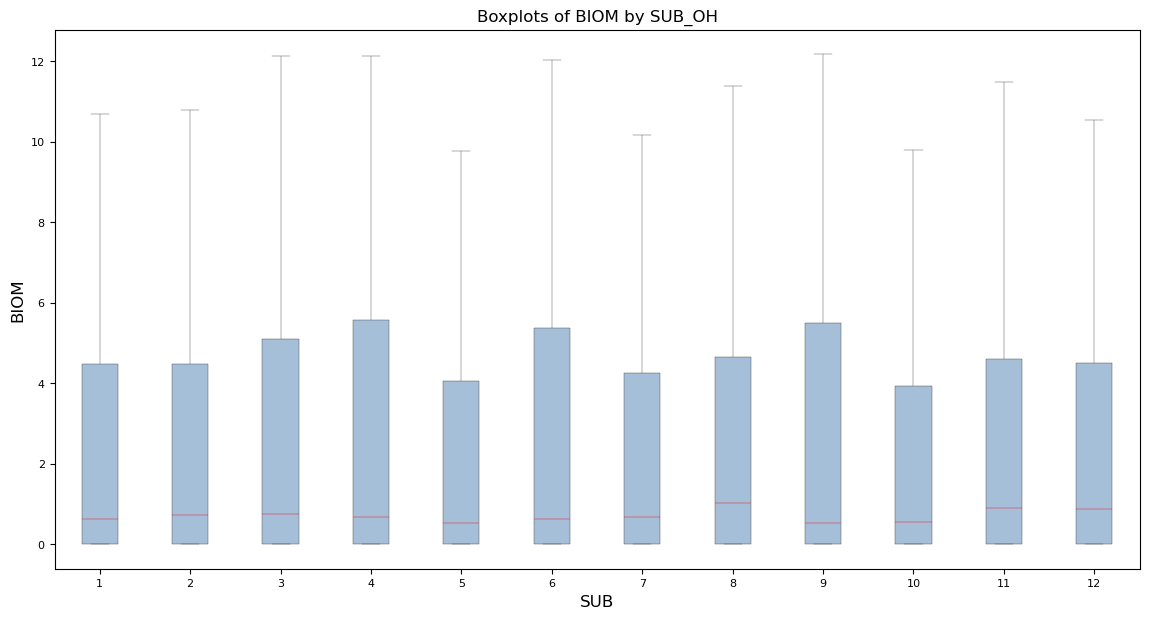

In [10]:
# boxplot lumped data at subbasin level
boxplot_byAttr(month_df,'SUB','BIOM','OH')

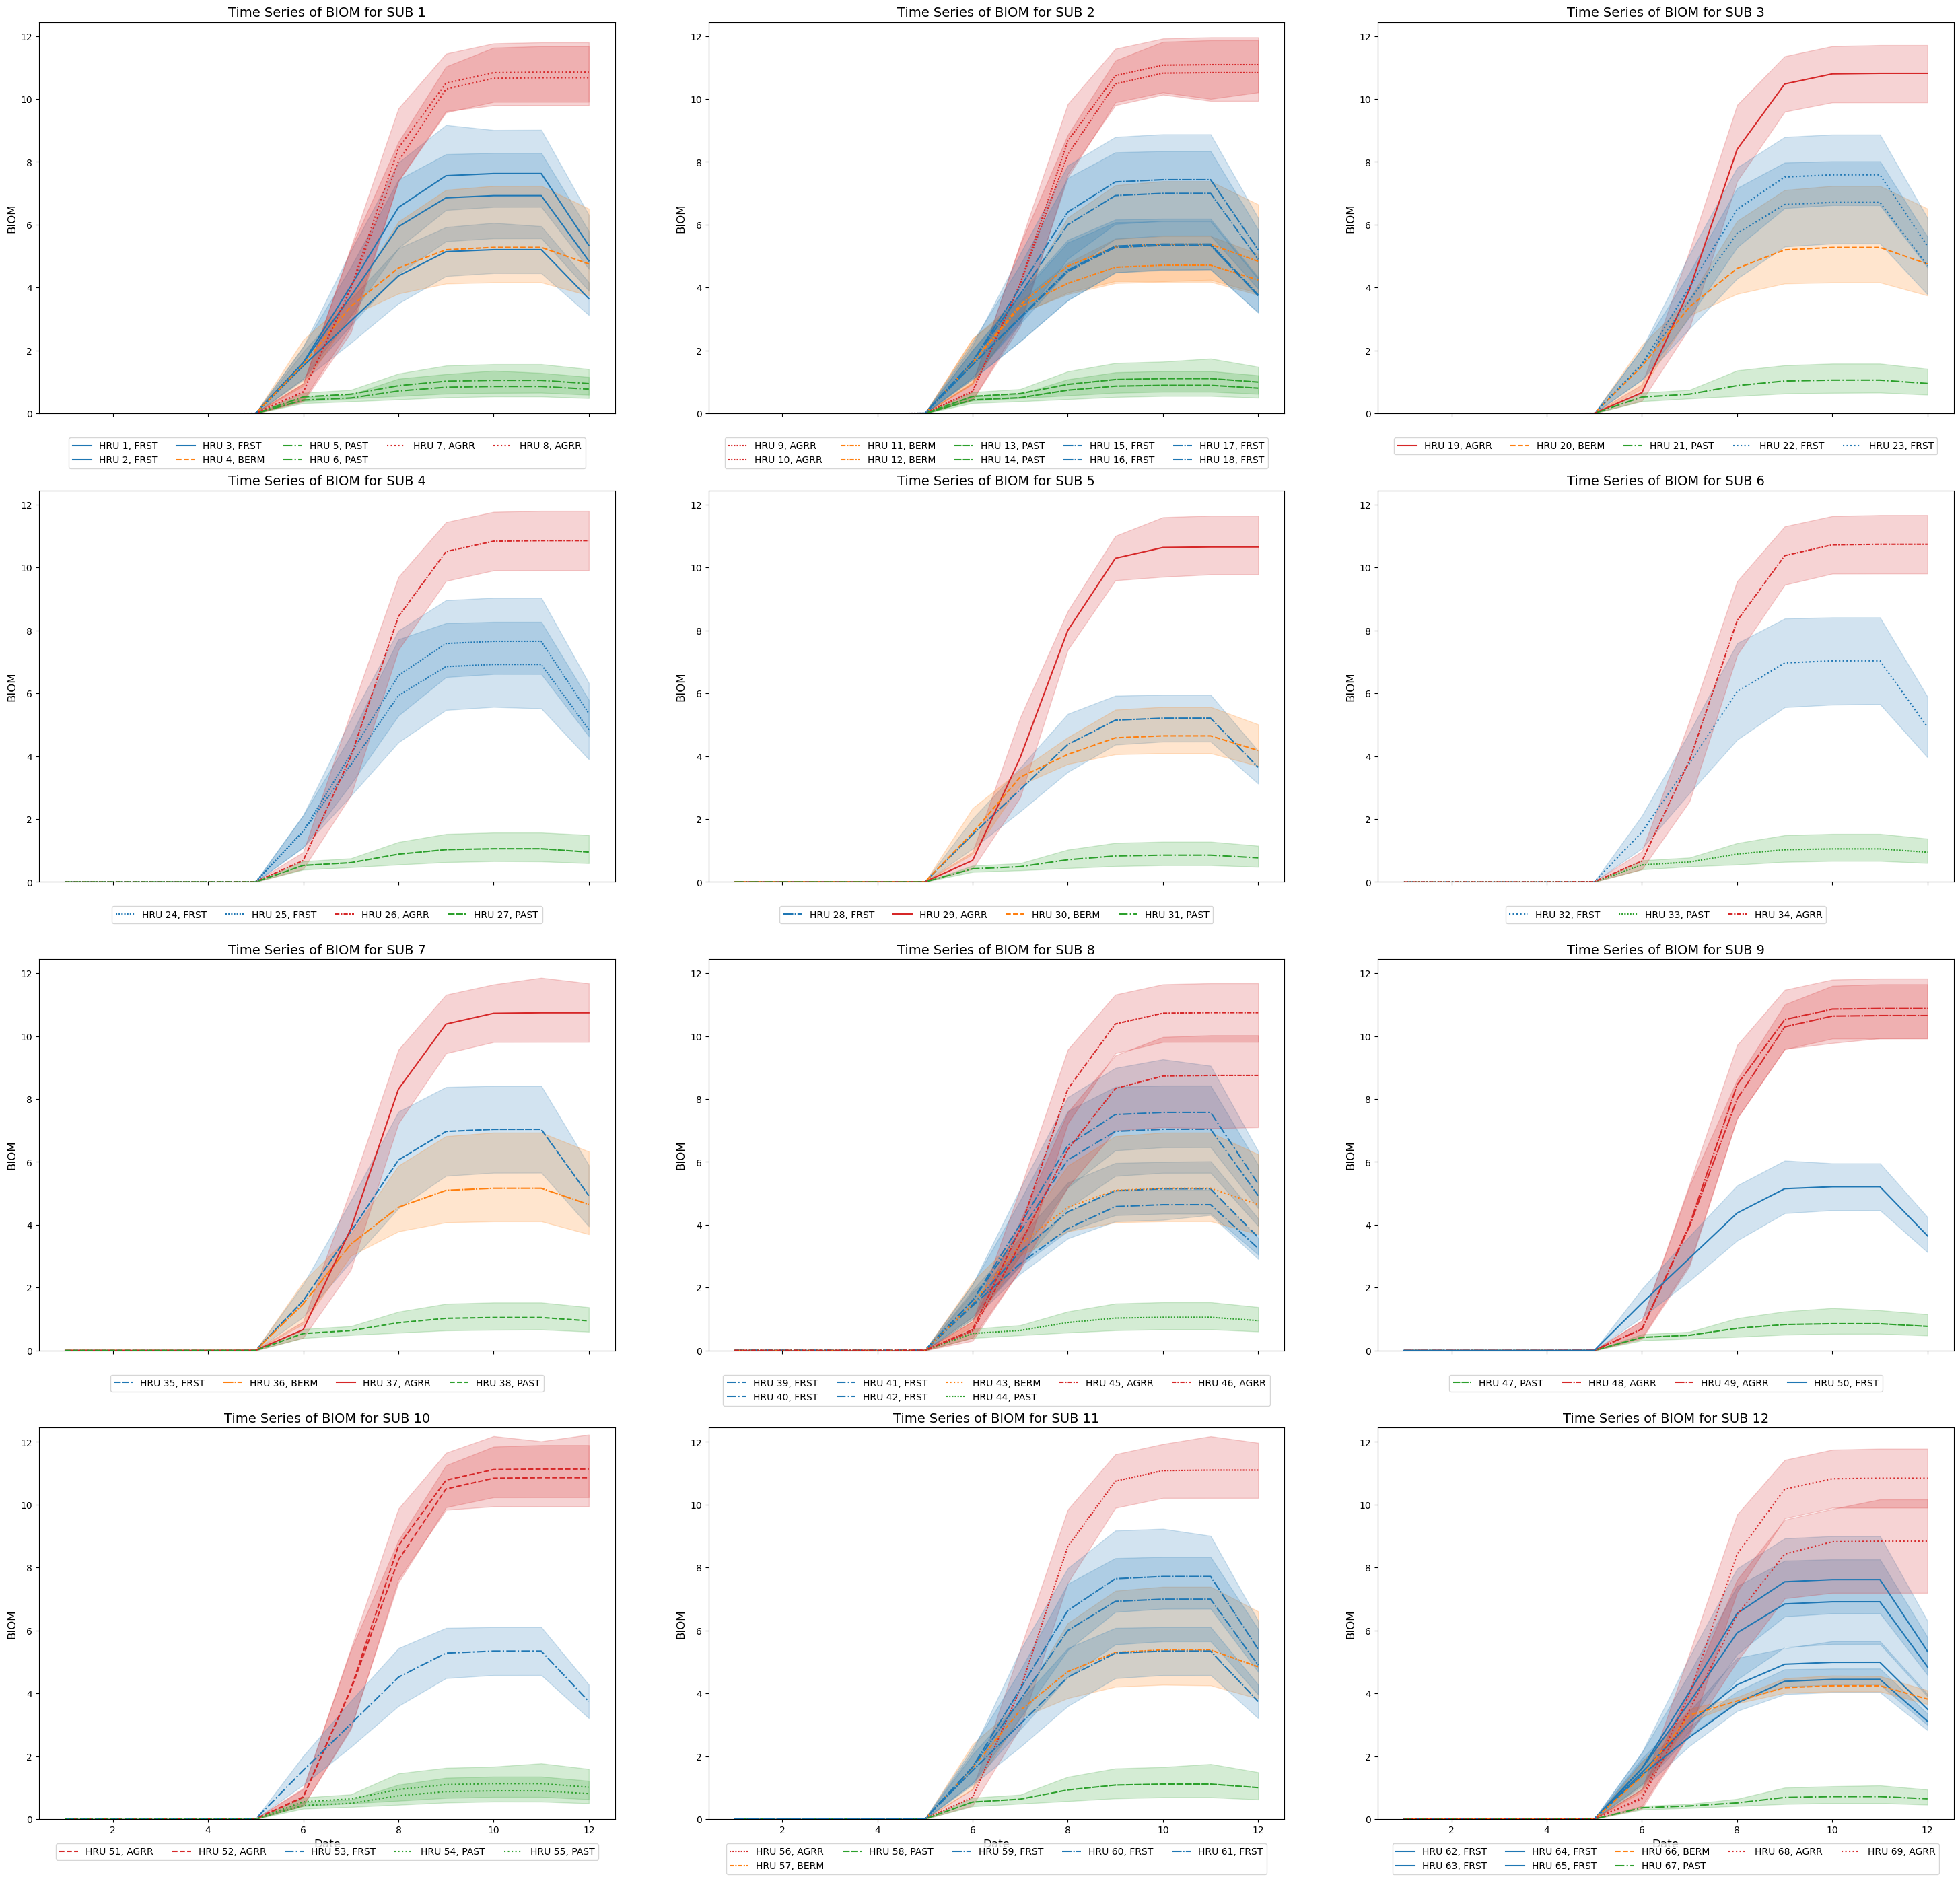

In [11]:
# Timeseries hru level: 
timeserie_plot(month_df, 'BIOM','OH',luc_filter=None,monthly_filter=True)

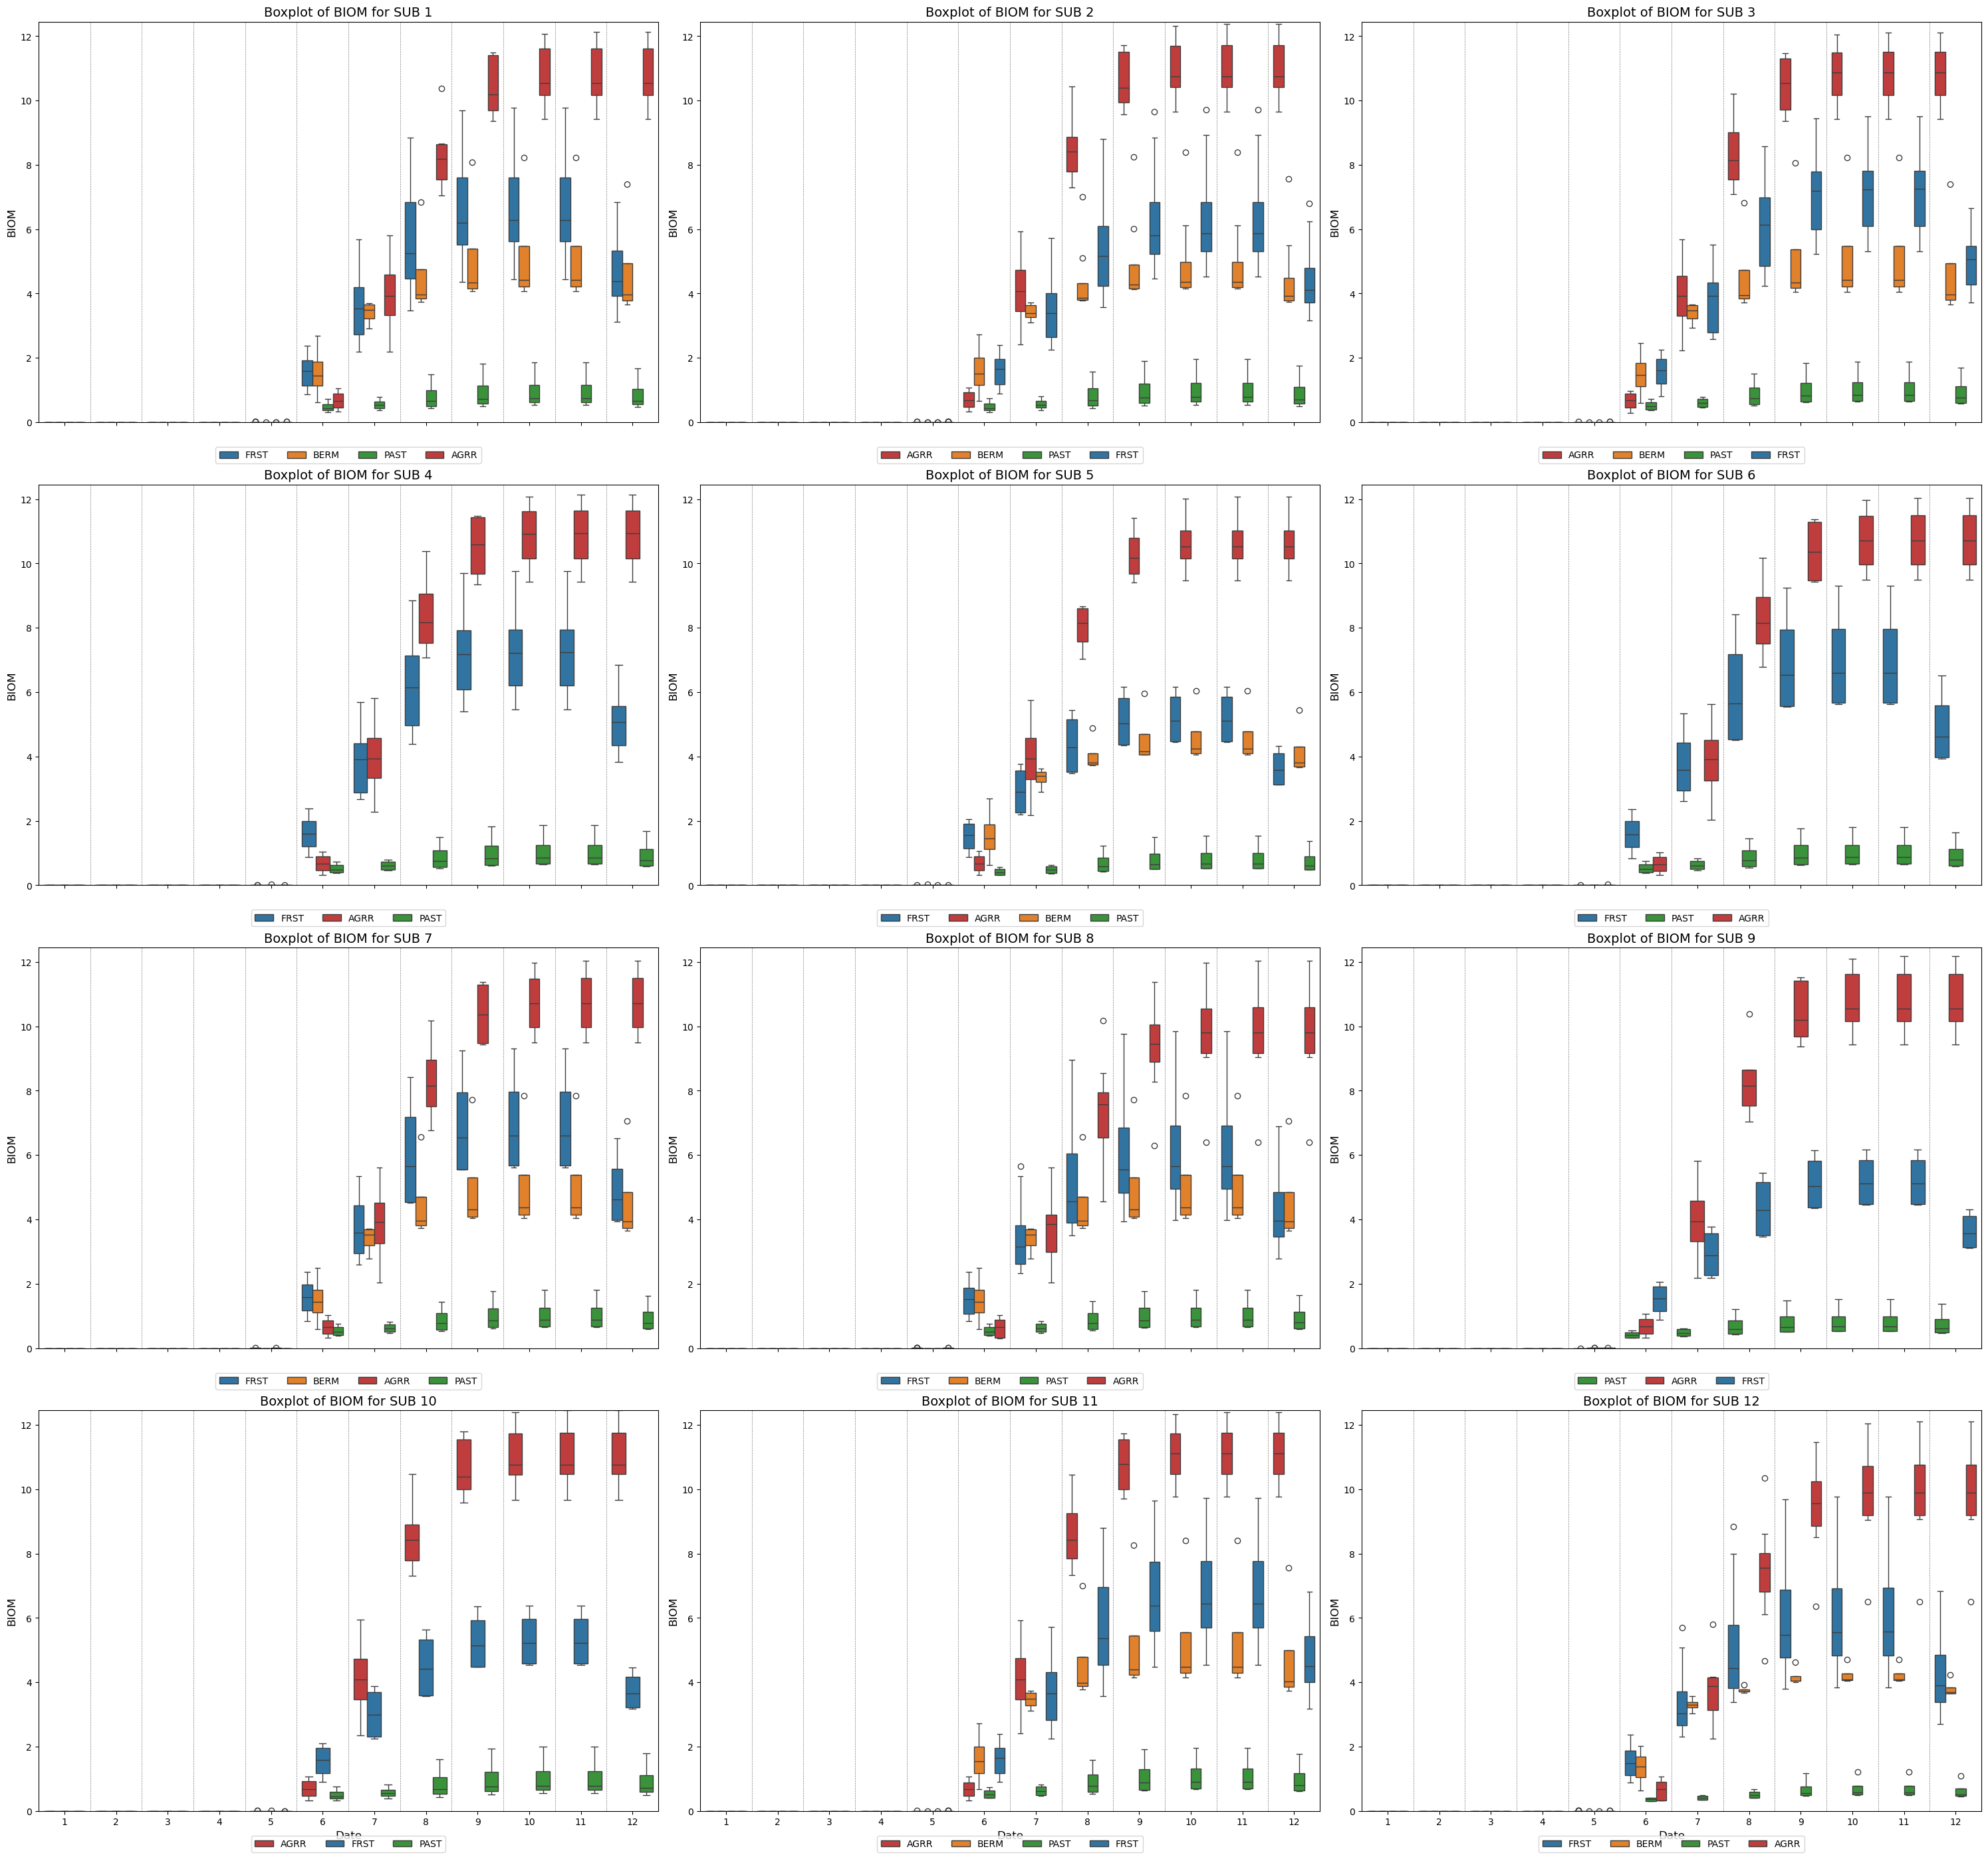

In [12]:
# boxplots of each subbasin grouped by land use/cover:
boxplot_time_sub(month_df, 'BIOM','OH',luc_filter=None)

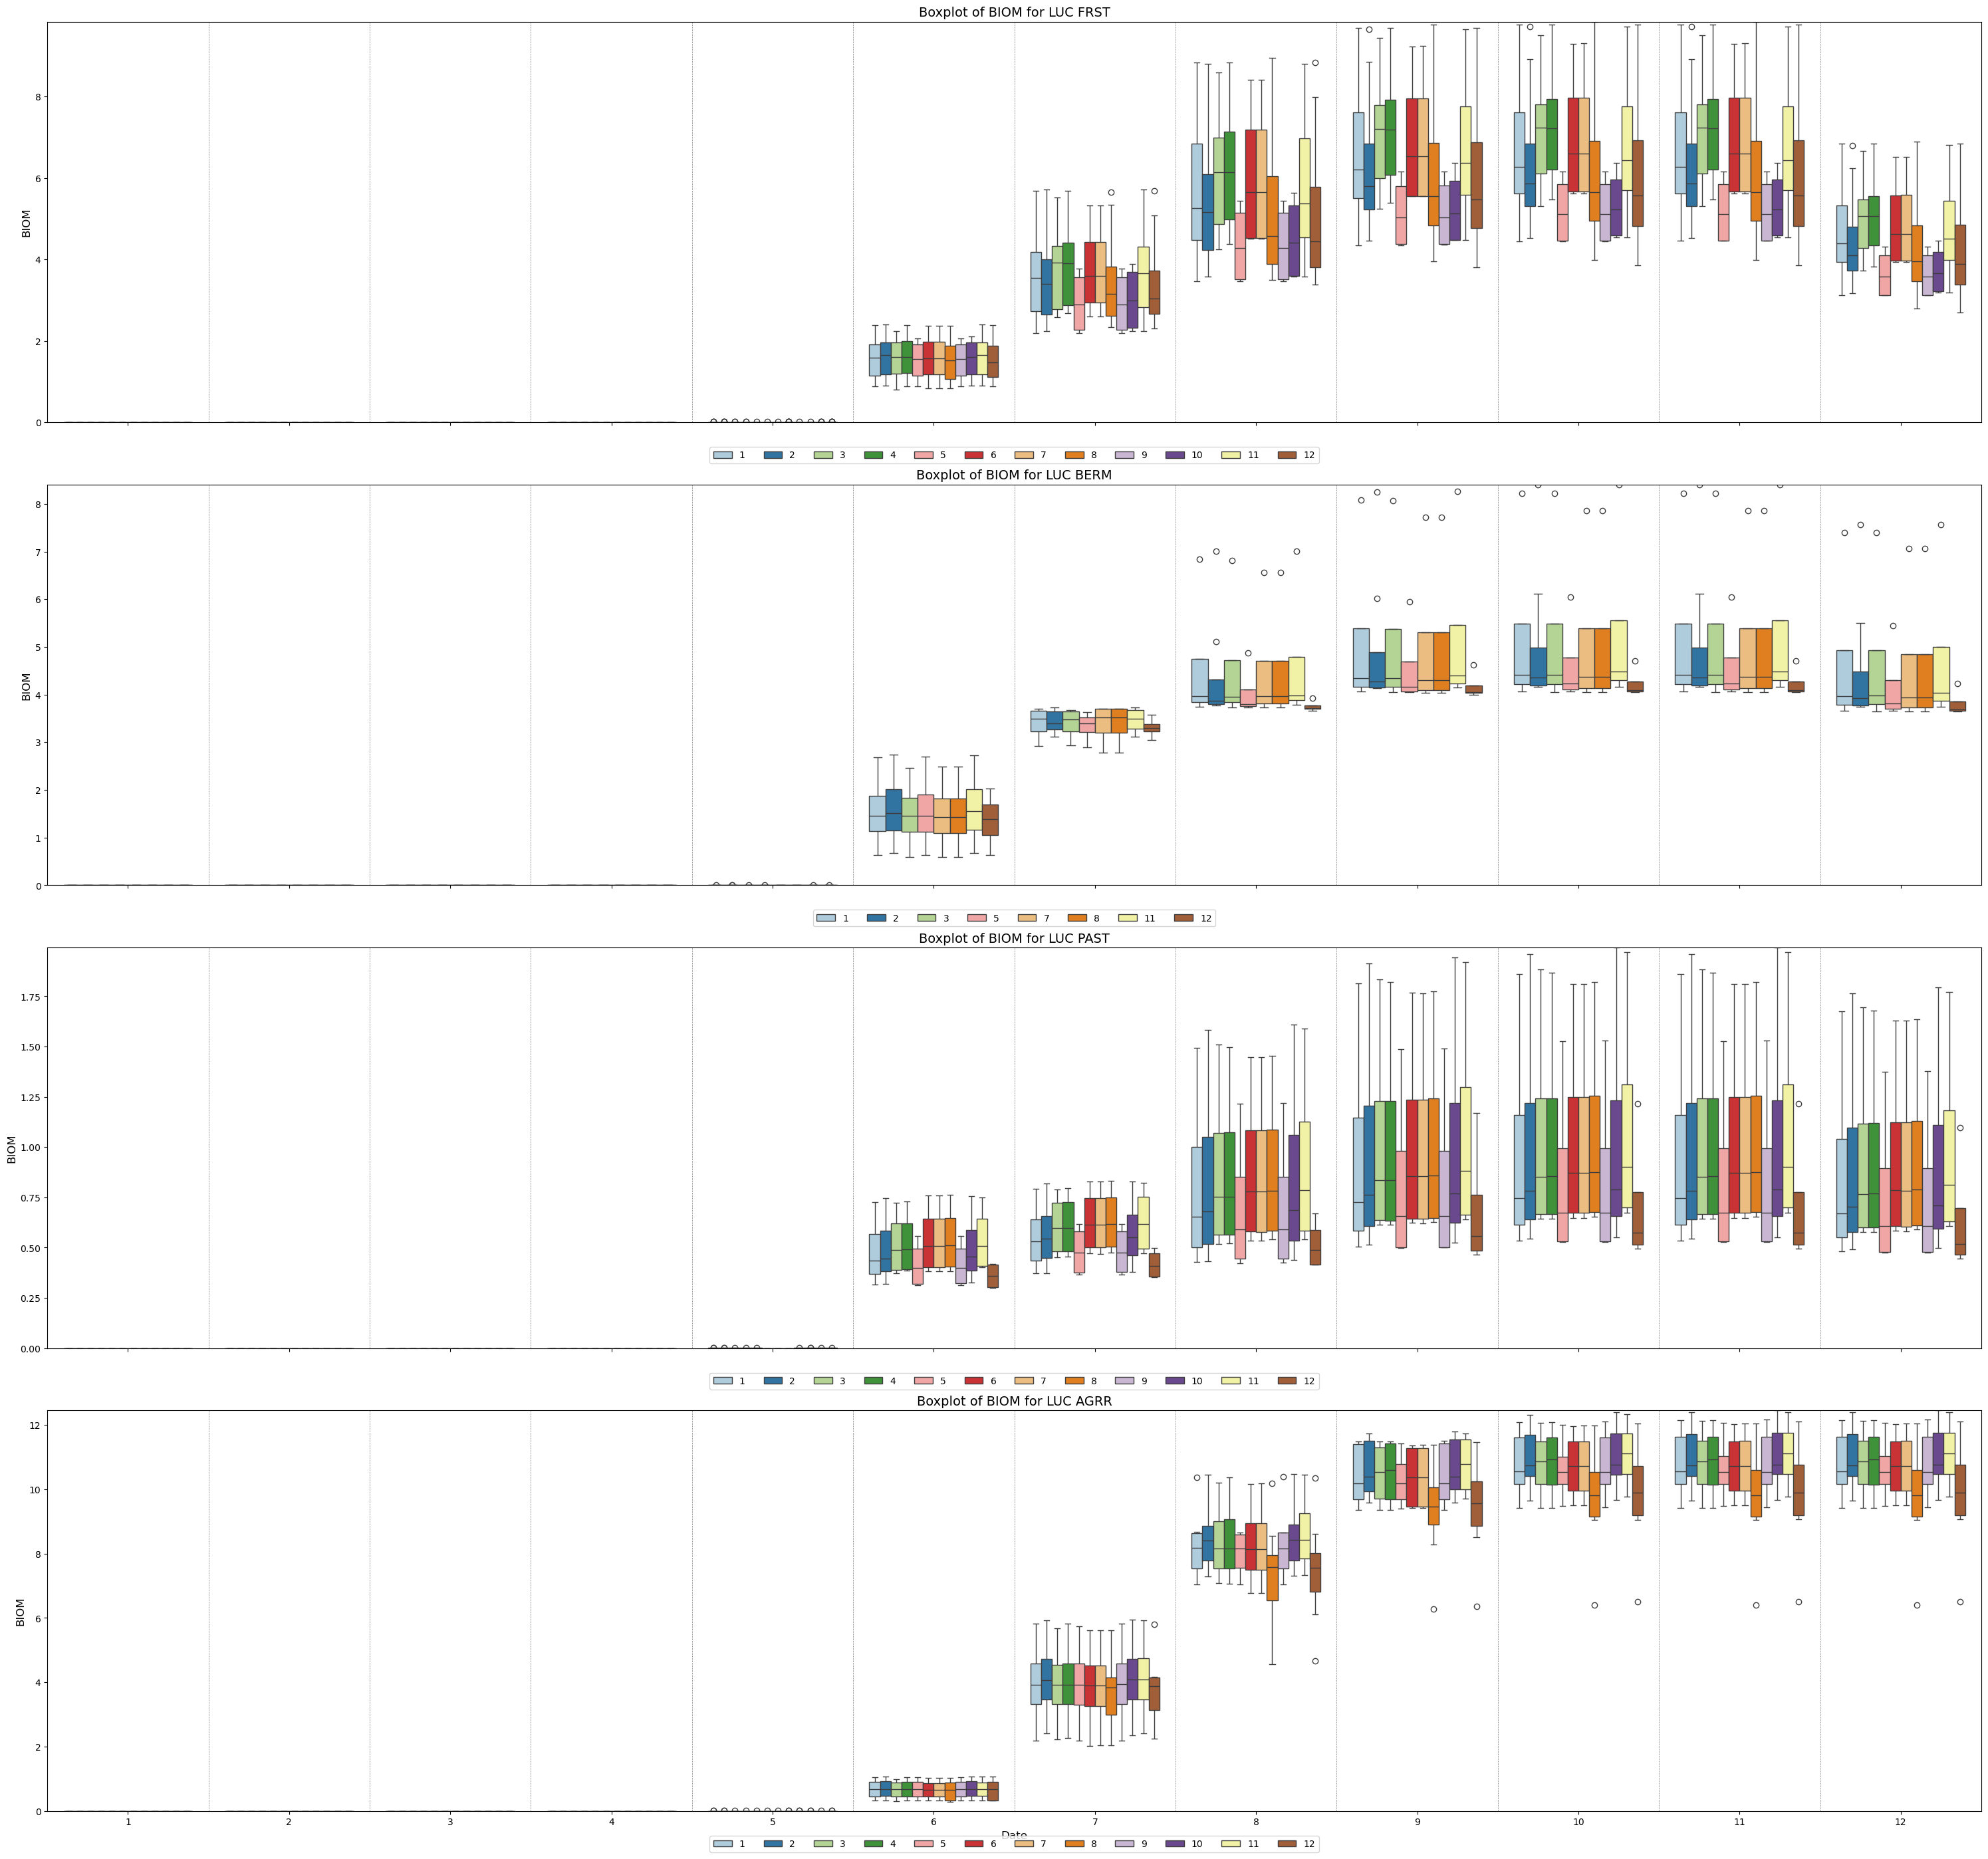

In [13]:
# boxplots of each land use/cover grouped by subbasin:
MaxBIOM_SUB_LUC=boxplot_time_luc(month_df, 'BIOM','OH',d_filter=None)

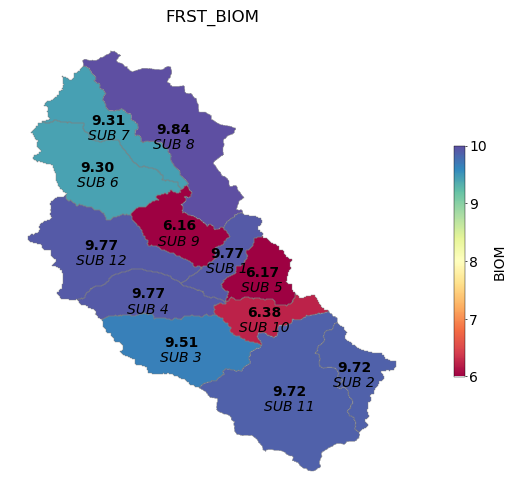

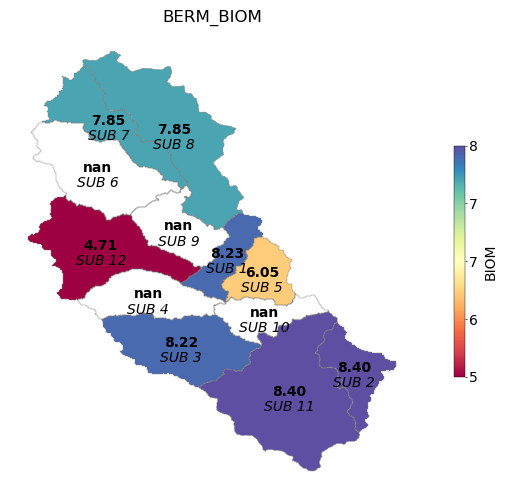

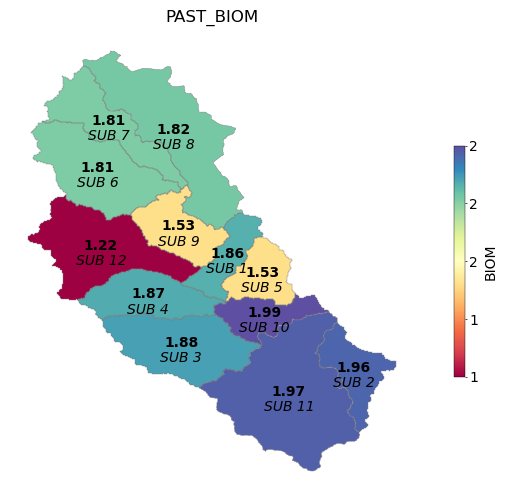

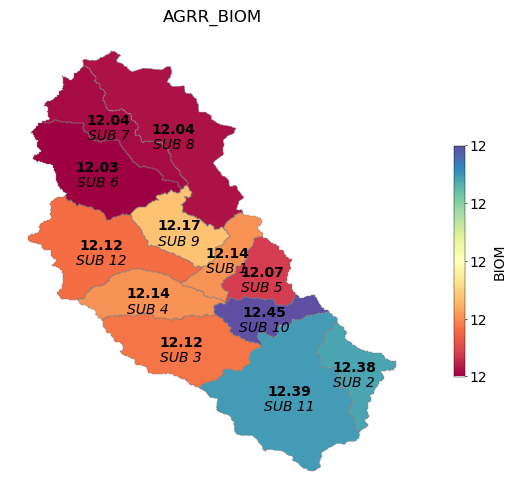

In [14]:
# map of the max information over subbasin levels
subbasin = '.\gis\subs1.shp'
for i in MaxBIOM_SUB_LUC:
    value= i[1]
    titlelabel=f'{i[0]}_{i[1].name}'
    plot_graph(subbasin,titlelabel, value,cbar_label='BIOM')

### 5.2 Visualization and analysis of output.mgt results

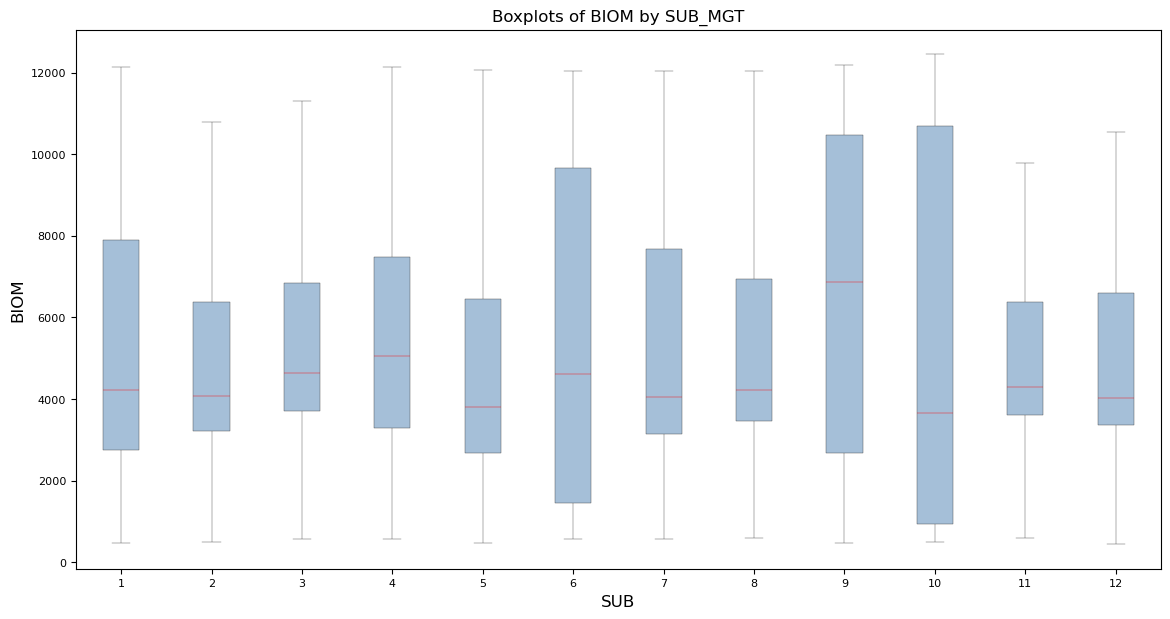

In [15]:
# boxplot lumped data at subbasin level
boxplot_byAttr(harv_df,'SUB','BIOM','MGT') 

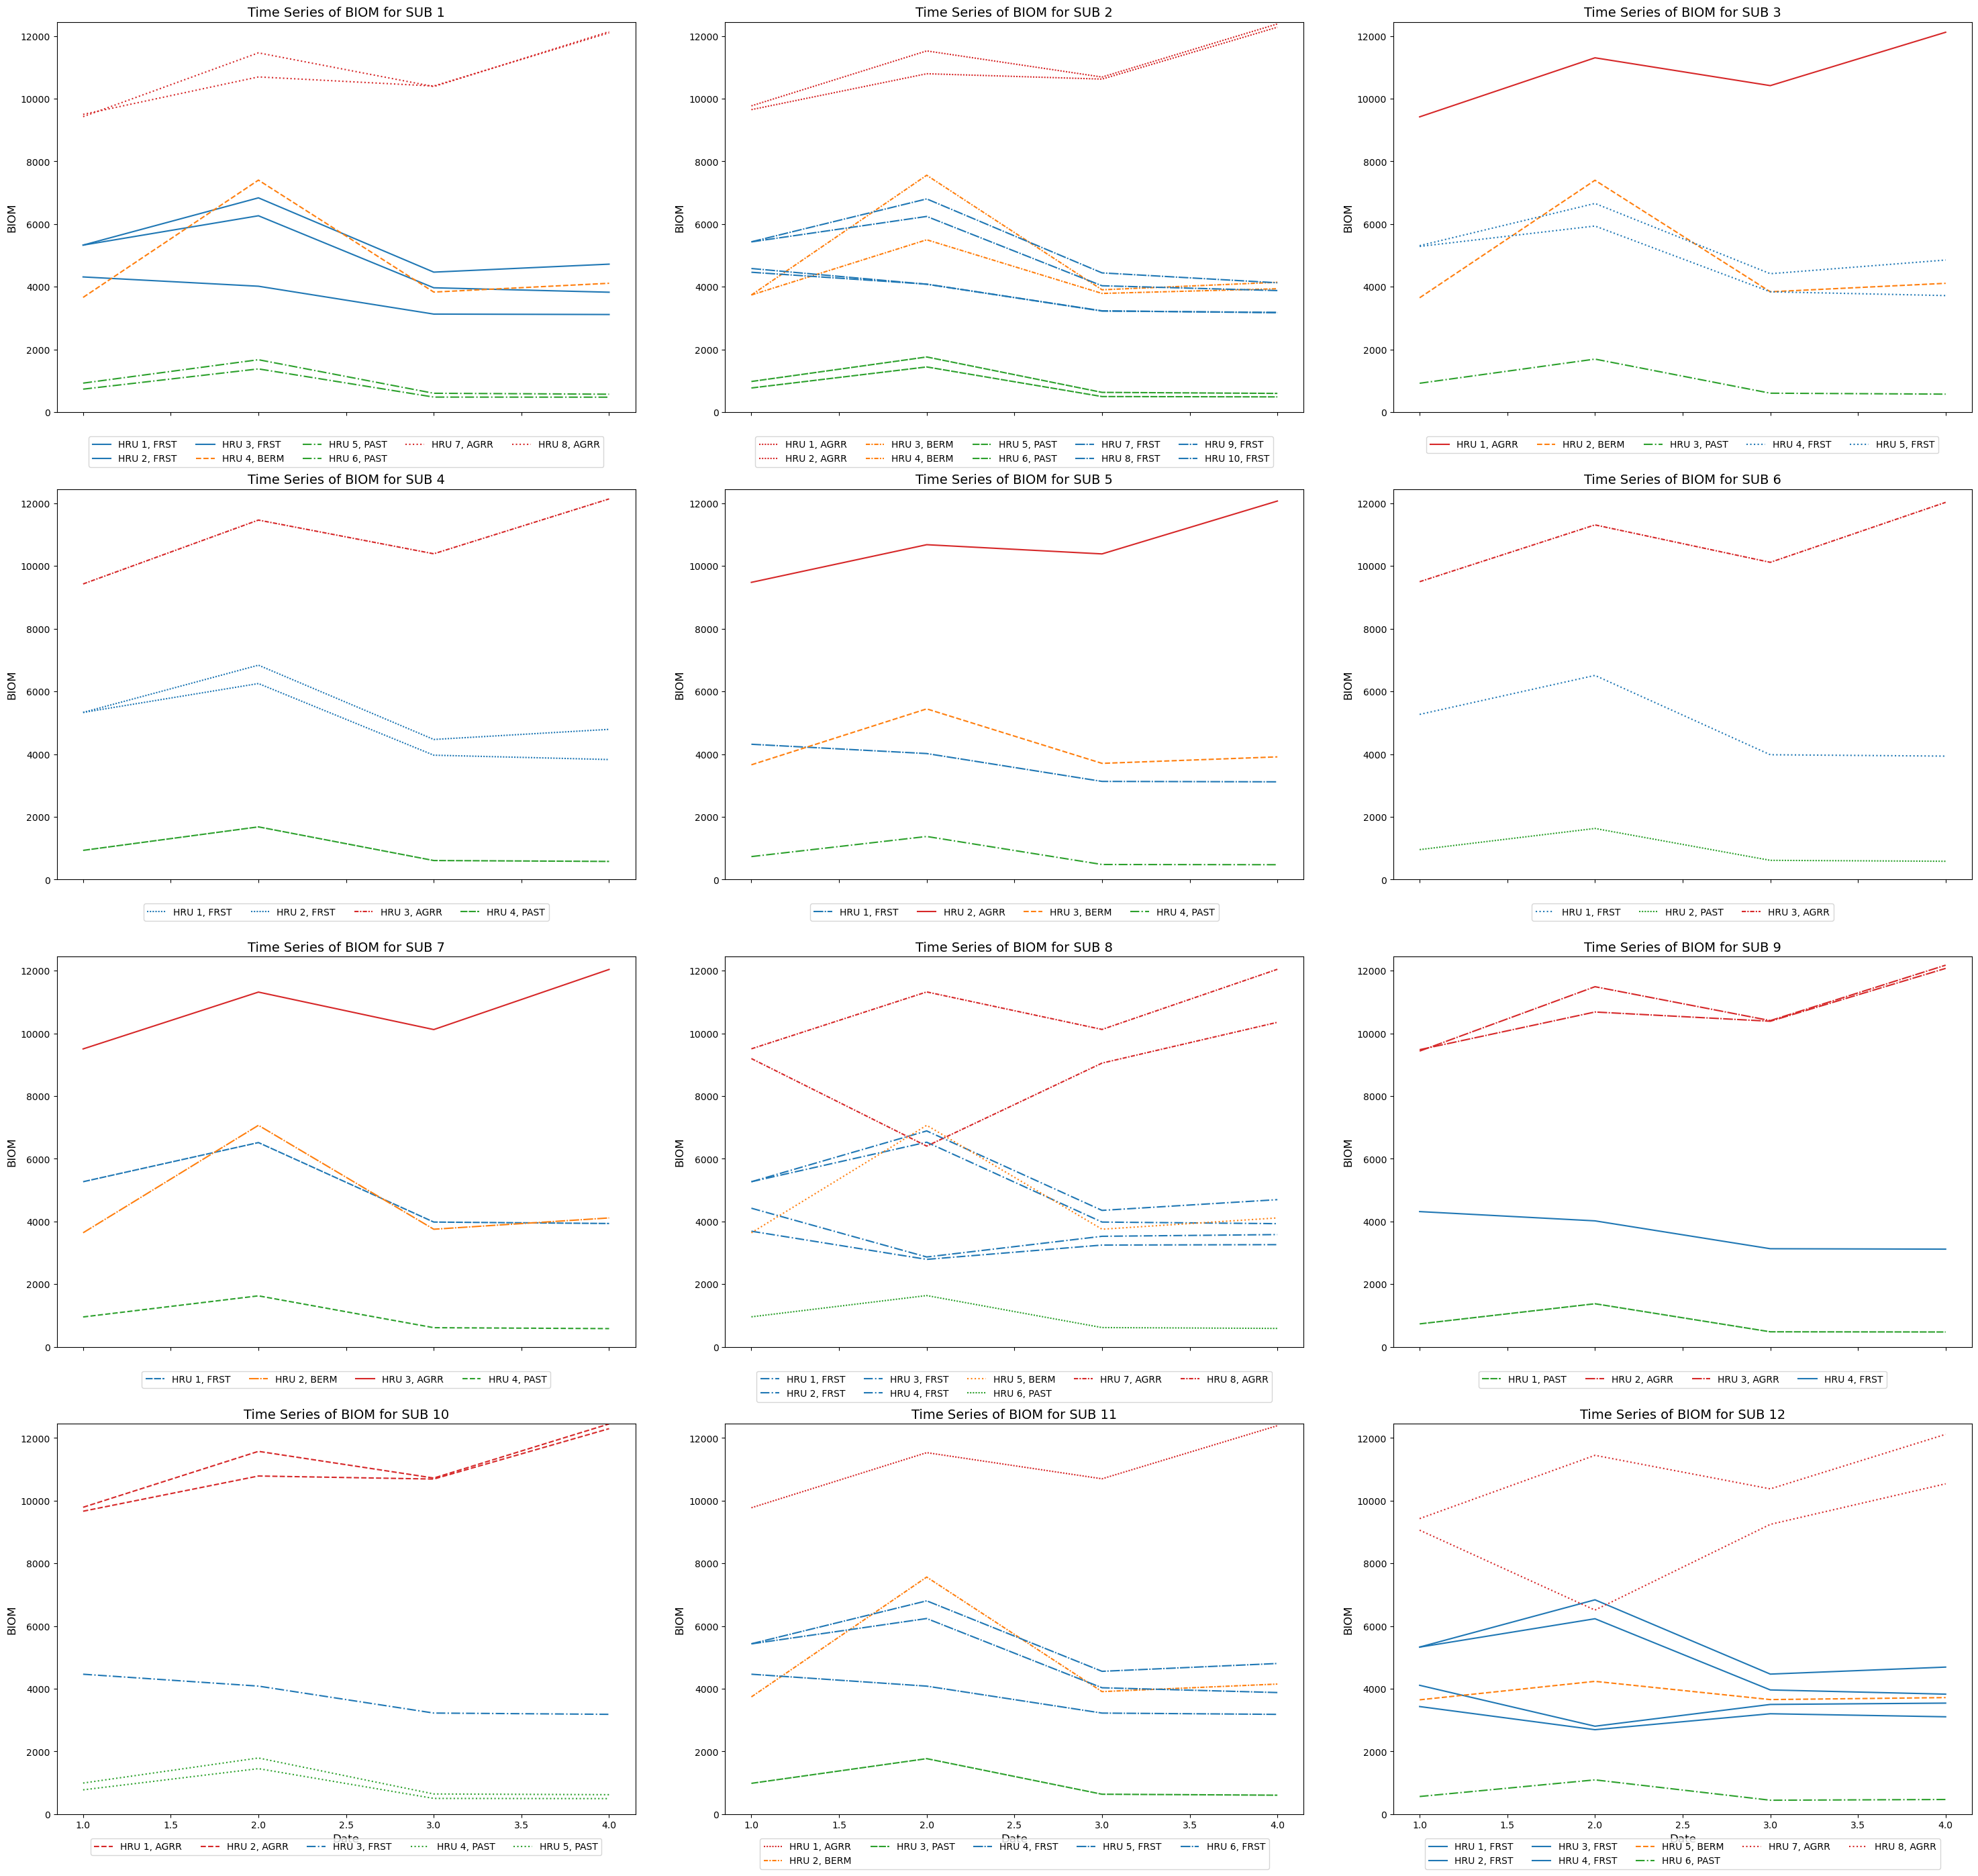

In [16]:
# Timeseries hru level: 
timeserie_plot(harv_df, 'BIOM','MGT',luc_filter=None,monthly_filter=False)

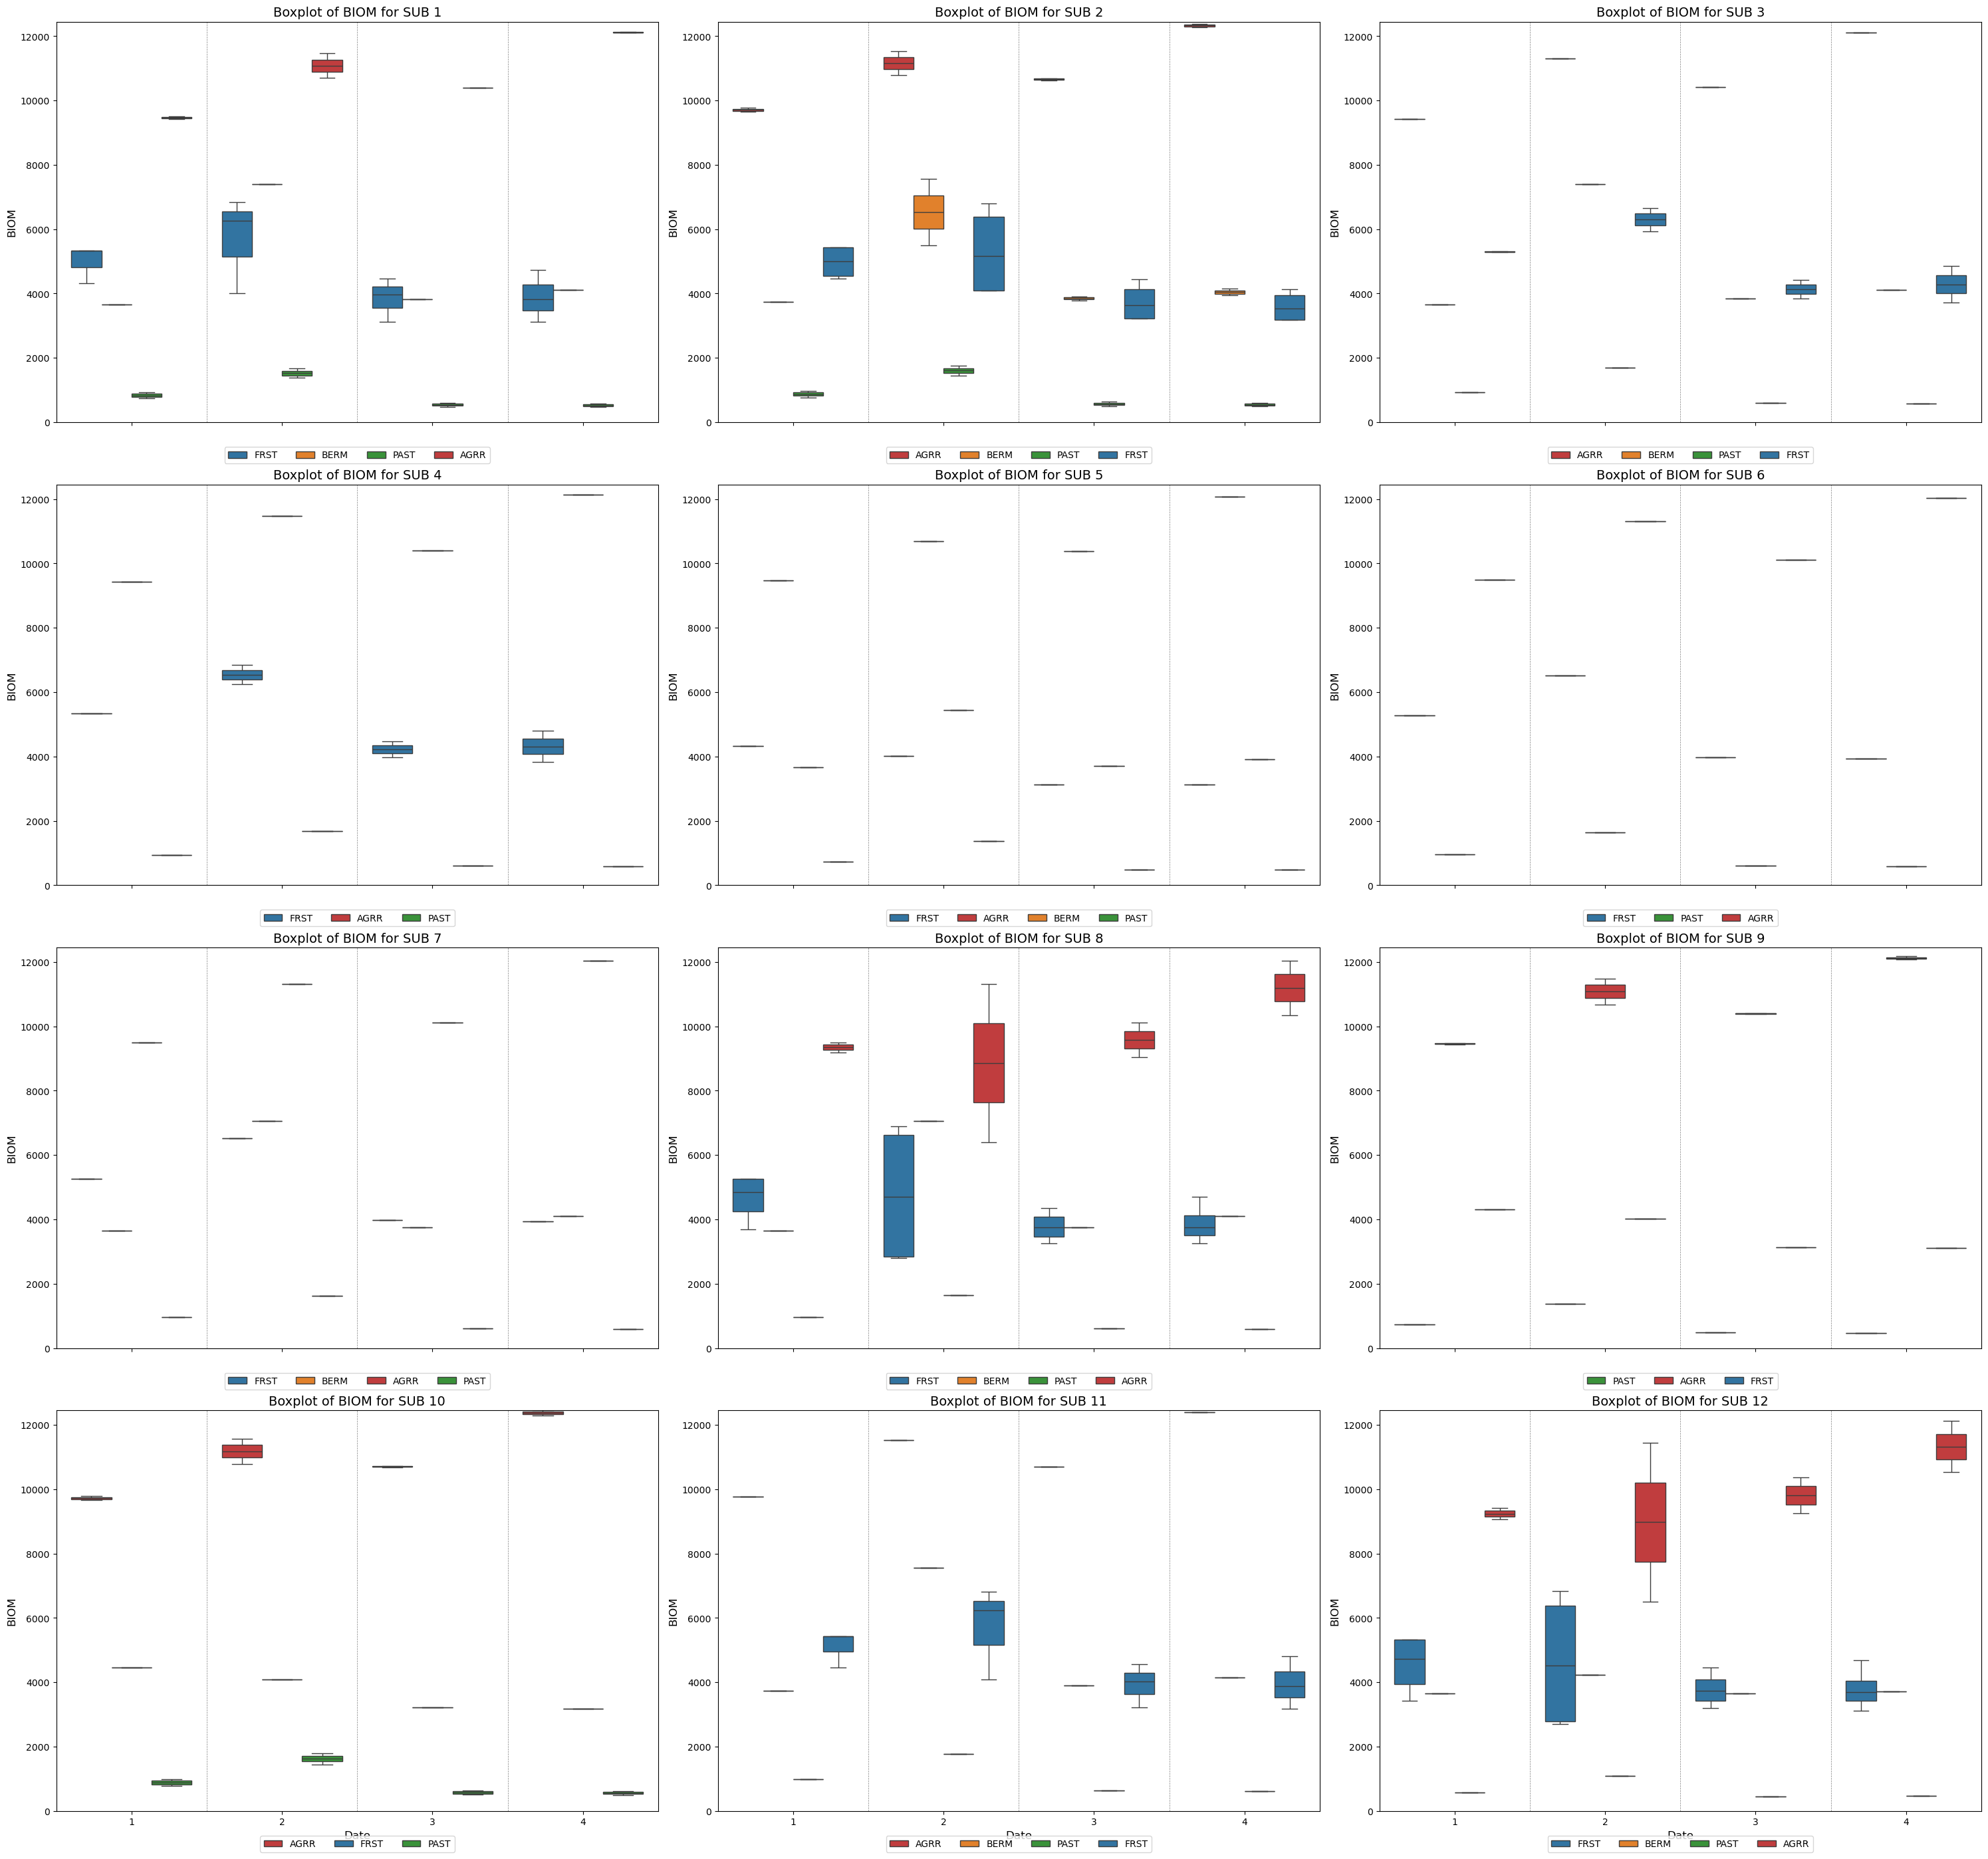

In [17]:
# boxplots of each subbasin grouped by land use/cover:
boxplot_time_sub(harv_df, 'BIOM','MGT',luc_filter=None)

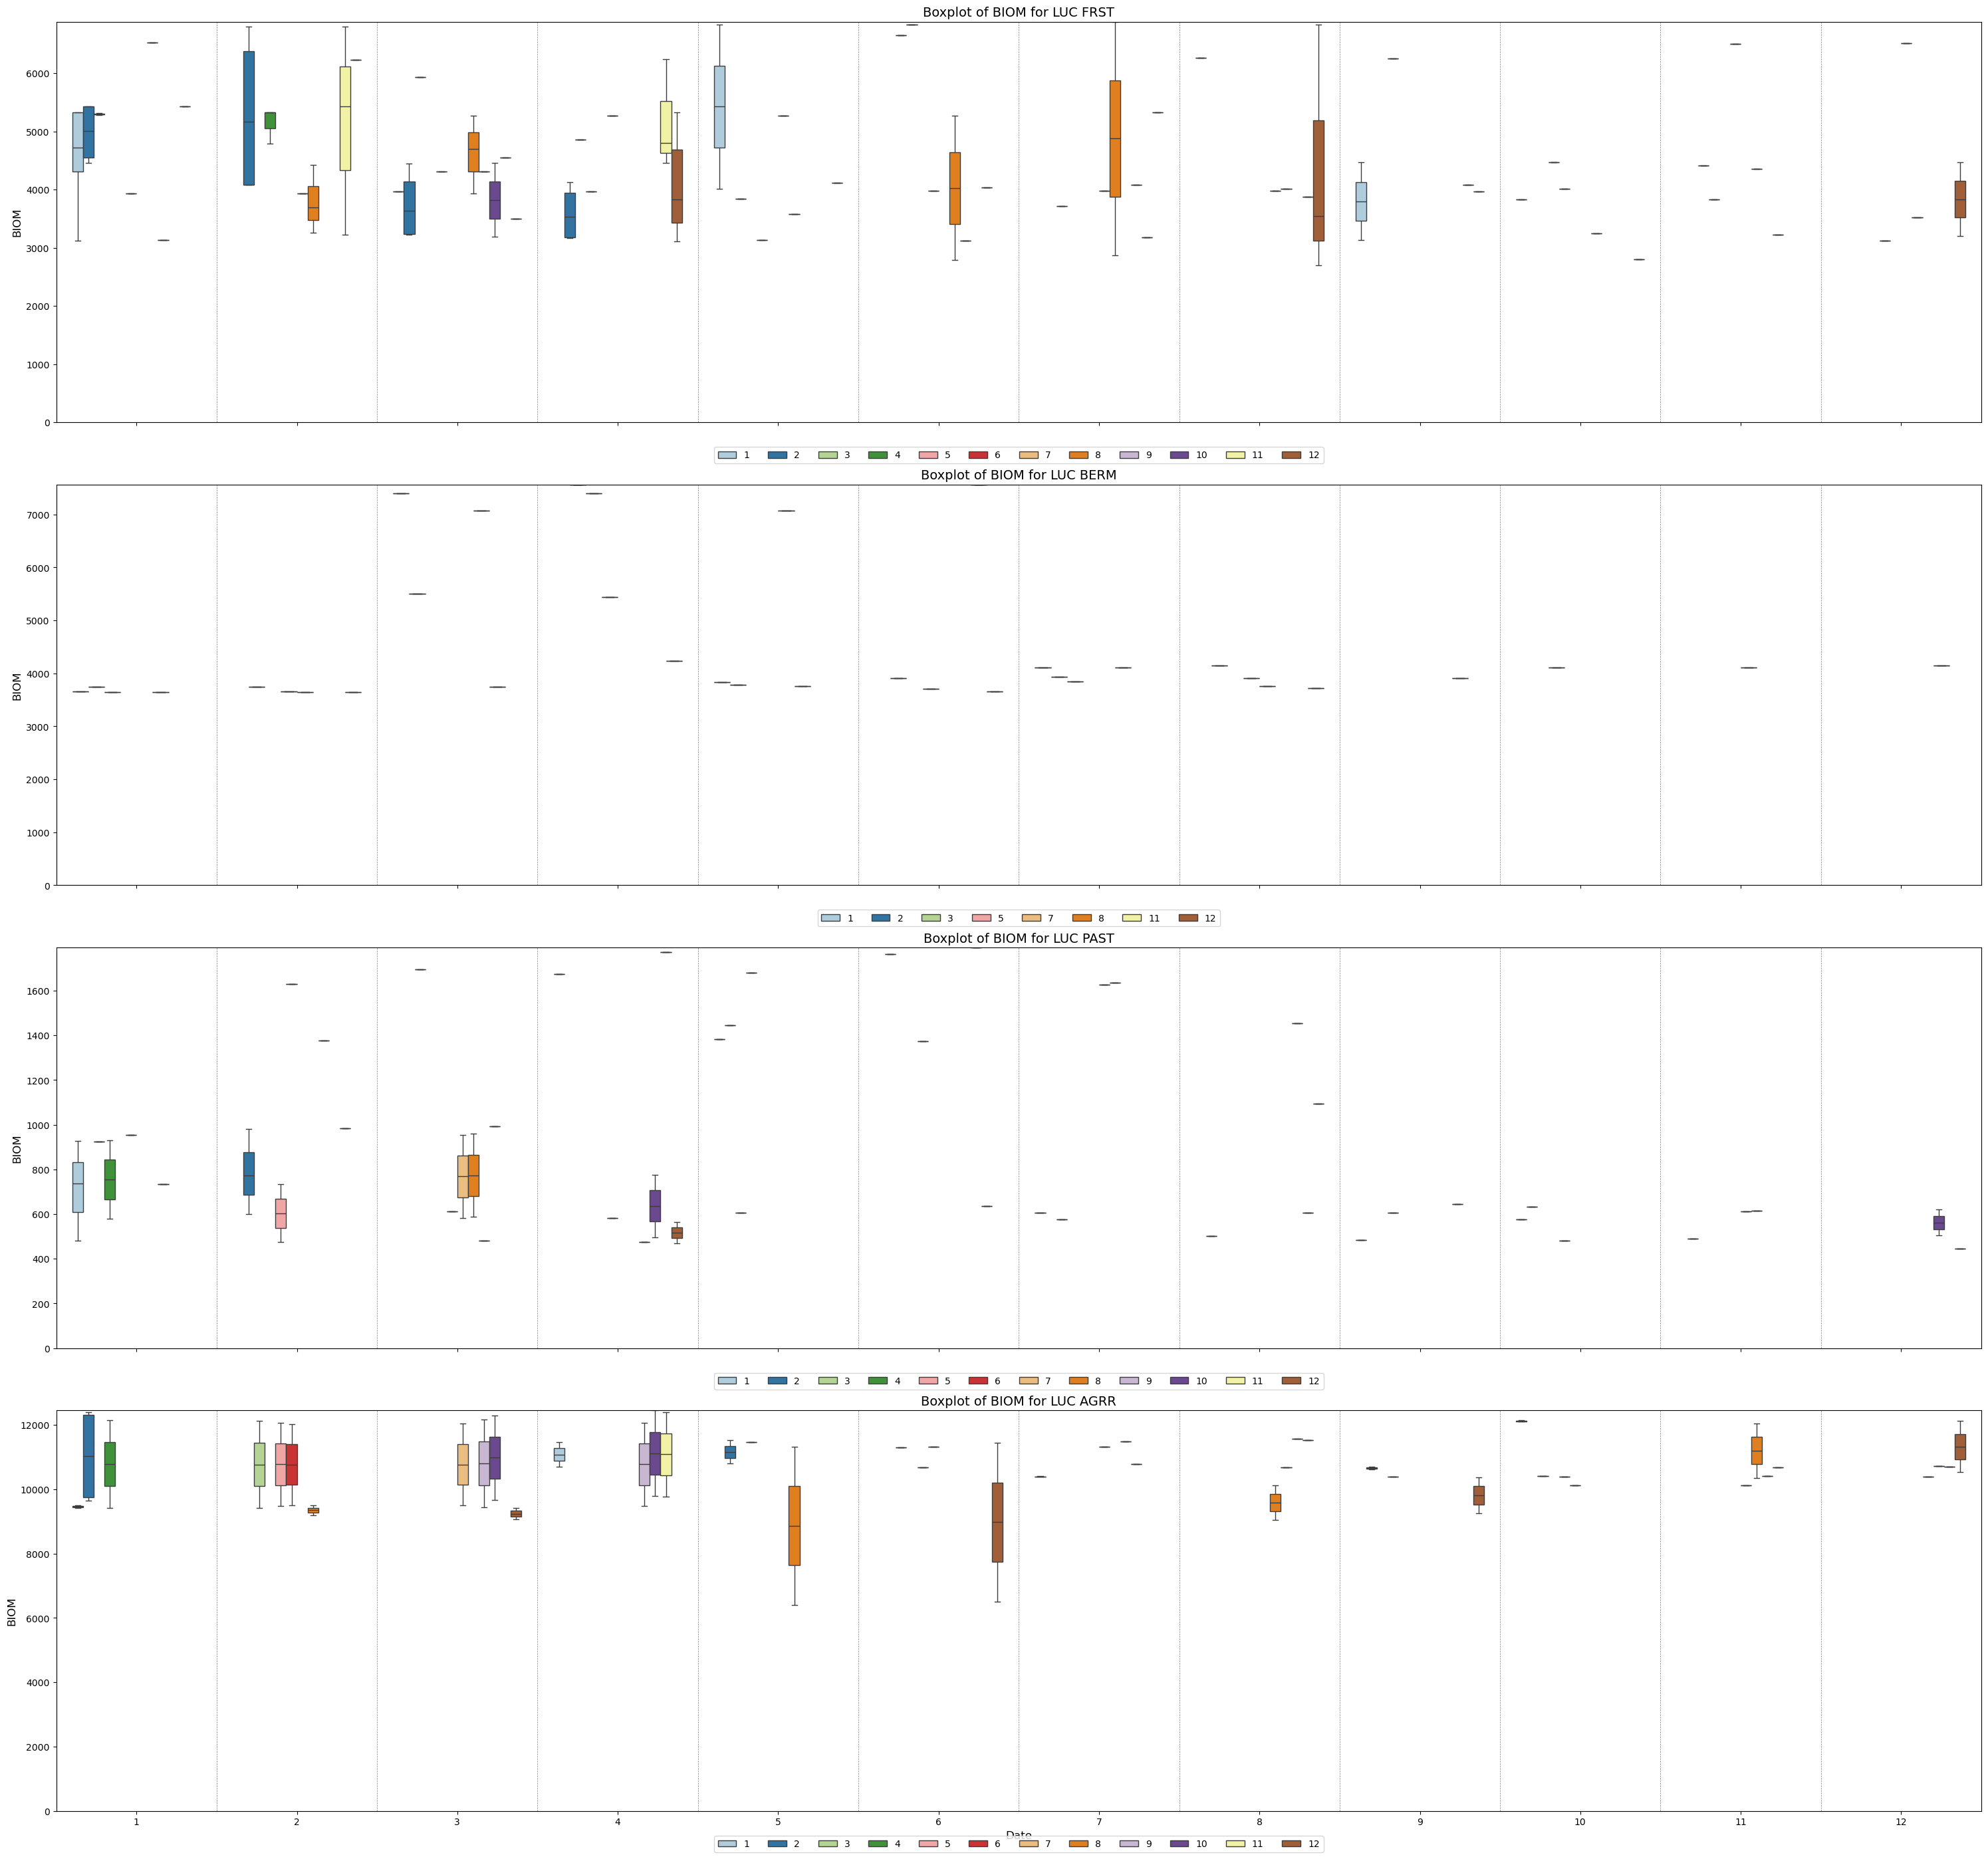

In [18]:
# boxplots of each land use/cover grouped by subbasin:
MaxBIOM_SUB_LUCMGT=boxplot_time_luc(harv_df, 'BIOM','MGT',d_filter=None)

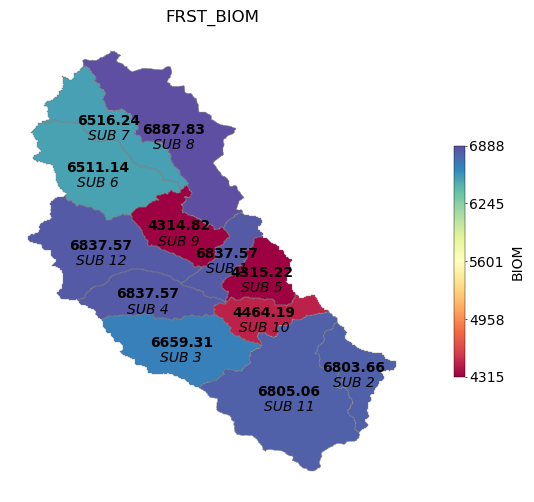

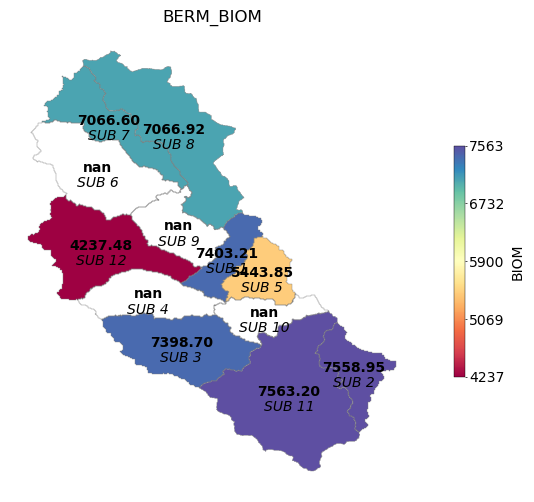

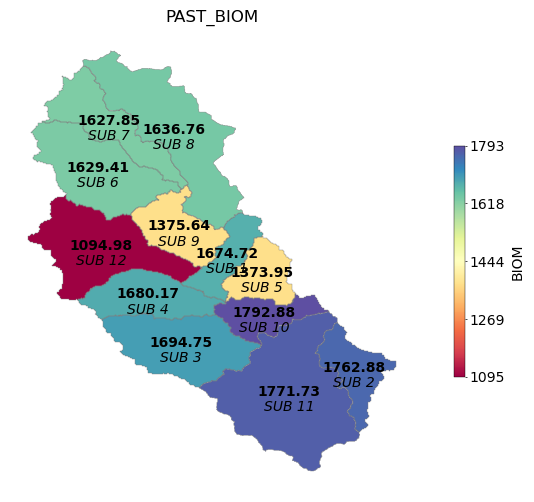

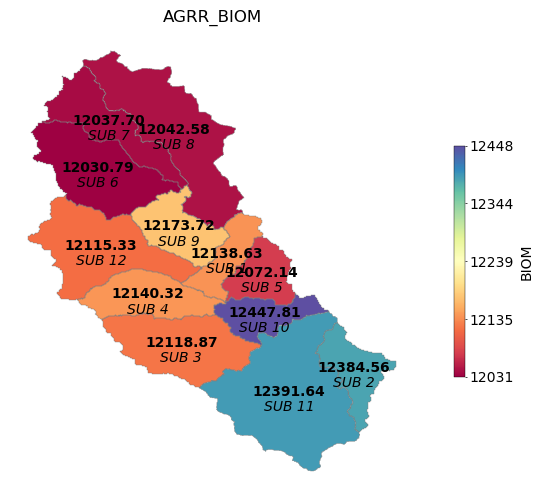

In [19]:
# map of the max information over subbasin levels
subbasin = '.\gis\subs1.shp'
for i in MaxBIOM_SUB_LUCMGT:
    value= i[1]
    titlelabel=f'{i[0]}_{i[1].name}'
    plot_graph(subbasin,titlelabel, value,cbar_label='BIOM')

### Task 5: 
1. What are the differences between the plant/crop simulations in output.hru,output.mgt, and output.std?\
2. What are the key take home messages?

### Prediction uncertainty analysis
Move on to 95PPU python code